## Raw Image Processing Example

This notebook will demonstrate how to quantify raw, multi-chamber images.

In [13]:
%run -m celldom.nb.logging
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
import celldom
import glob
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from celldom.core import cytometry
from celldom.config import experiment_config

### Output Location

```celldom.get_data_dir()``` will return a path to a directory that is shared between the container and the host machine.  This makes it possible to save results somewhere that are still available after the container is shutdown/deleted. 

You can instead pick an output path like ```/tmp/test_output``` but that's generally only helpful for testing and debugging -- otherwise, output paths should always be chosen like this:

In [14]:
celldom.get_data_dir()

'/lab/data/celldom'

In [35]:
# This the ulimate location for any results generated:
output_dir = osp.join(celldom.get_data_dir(), 'output', 'experiment_00')
output_dir

'/lab/data/celldom/output/experiment_00'

## Experiment Configuration

Next, the experiment configuration determines which chip configuration is being used as well as how certain properties are parsed from raw file paths.  This can be anywhere, but generally you would want it to come from a github repository like this (where ```celldom.get_repo_dir()``` is similar to ```celldom.get_data_dir()``` in that it will likely be a shared directory:

In [17]:
exp_config_path = osp.join(
    celldom.get_repo_dir(), 'config', 
    'experiment', 'experiment_example_01.yaml'
)
exp_config_path

'/lab/repos/celldom/config/experiment/experiment_example_01.yaml'

In this case specifically, this experiment was meant to process data stored like this:

    /some/path/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif
    
This was real data and the information in the path is processed based on what's in the configuration:

In [18]:
!cat $exp_config_path

name: Test Experiment 1
chip: {name: chip_01}
cytometer: {name: cytometer_01}
metadata:
  # Example file path: 2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif
  fields:
    datetime:
      regex: '[0-9.]{15}'
      format: '%Y.%m.%d.%H%M'
    cohort: 'NoDrug|1nMQuiz'
    concentration: '[1I]Mperml'
    chip: 'Chip2'
    street: '[0-9]{3}'
    apartment: '[0-9]{3}'
    z: 'z[_mp][0-9]{1}'
  path_format: '.*{datetime} MOLM13 {cohort} {concentration} {chip}/BF_ST_{street}_APT_{apartment}_{z}.tif'


In [19]:
# The configuration above is then wrapped in a class that takes care of the path processing:
exp_config = experiment_config.ExperimentConfig(celldom.read_config(exp_config_path))

# Which can then interpret paths like this:
exp_config.parse_path(
    '/some/path/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif'
)

{'apartment': '000',
 'chip': 'Chip2',
 'cohort': 'NoDrug',
 'concentration': '1Mperml',
 'datetime': Timestamp('2018-05-31 16:10:00'),
 'street': '000',
 'z': 'zm3'}

### Choose Images

The last piece of information need is files to process.  This snippet will grab all files available from a dataset and then randomly sample them:

In [20]:
data_dir = osp.join(celldom.get_data_dir(), 'dataset', 'dataset03')
data_dir

'/lab/data/celldom/dataset/dataset03'

In [21]:
!ls $data_dir | head

2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2
2018.05.31.1723 MOLM13 1nMQuiz 1Mperml Chip2
2018.05.31.2109 MOLM13 NoDrug 1Mperml Chip2
2018.05.31.2215 MOLM13 1nMQuiz 1Mperml Chip2
2018.06.01.1045 MOLM13 NoDrug 1Mperml Chip2
2018.06.01.1129 MOLM13 1nMQuiz 1Mperml Chip2
2018.06.01.1622 MOLM13 NoDrug 1Mperml Chip2
2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2
2018.06.01.2307 MOLM13 NoDrug 1Mperml Chip2
2018.06.02.0005 MOLM13 1nMQuiz 1Mperml Chip2


In [22]:
# Fetch all files matching a pattern like $data_dir/*MOLM13*Chip2/*.tif
files = glob.glob(osp.join(data_dir, '*MOLM13*Chip2', '*.tif'))

print('Number of total files found:', len(files))
print('First 5 files:')
files[:5]

Number of total files found: 31759
First 5 files:


['/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm6.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm9.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zp3.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zp6.tif']

In [23]:
# Randomly sample down to something small for the example
files = pd.Series(files).sample(n=10, random_state=celldom.seed)
len(files)

10

<Figure size 432x288 with 0 Axes>

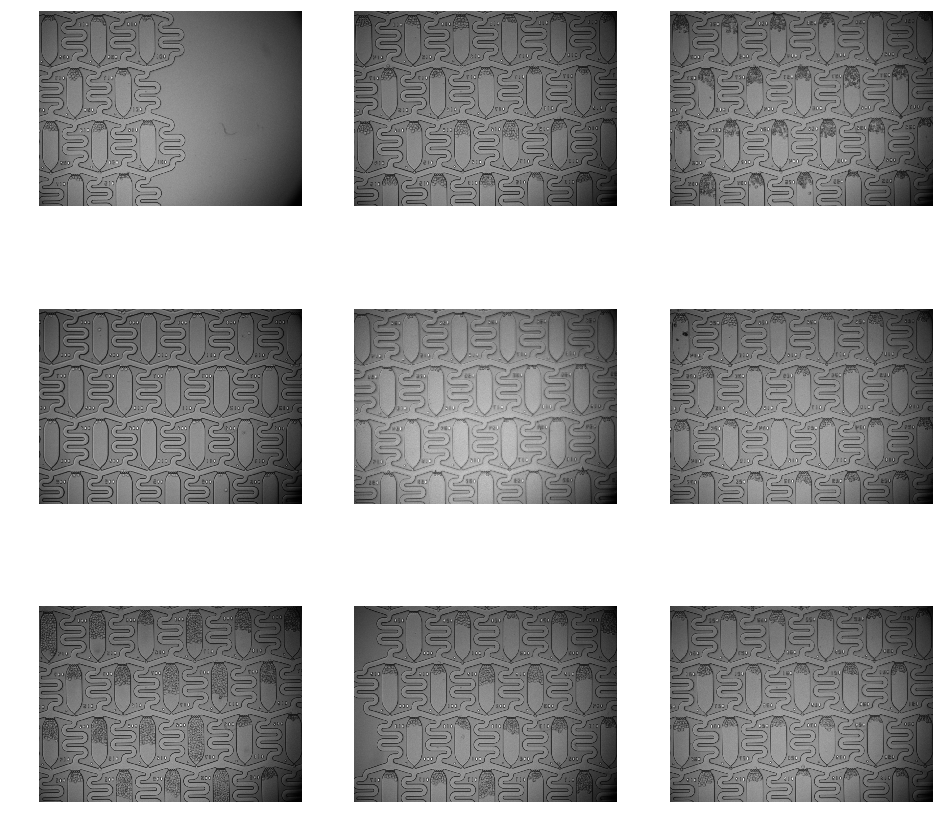

In [24]:
# As a sanity check, see what a few of the images look like:
plt.gray()
display_images([io.imread(f) for f in files[:9]], cols=3, size=16)

### Run Processing

All that is left to do is run the processing class with the arguments from above:

In [26]:
%%time
with cytometry.Cytometer(exp_config, output_dir) as cytometer:
    for i, f in tqdm.tqdm(enumerate(files), total=len(files)):
        try:
            # Analyze the image
            raw_data, apartment_data, cell_data = cytometer.run(f)

            # Save the results (more on what they are next)
            cytometer.save(raw_data, apartment_data, cell_data)
        except Exception as e: 
            print('A failure occurred processing file {}'.format(f))
            print(e)

100%|██████████| 10/10 [00:41<00:00,  4.12s/it]

CPU times: user 56.6 s, sys: 58.6 s, total: 1min 55s
Wall time: 56.3 s


### Results (Short Version)

A lot of information is saved while processing runs, but the data is basically broken down to 3 levels:

- The "raw" image level (```raw_data``` above)
- The apartment level (```apartment_data``` above)
- The cell level (```cell_data``` above)

Here are some of the more interesting bits from the apartment and cell levels:

In [27]:
# This data frame contains the inferred st/apt numbers of apartments, cell counts,
# metadata from the original file like date and treatment group, and a "focus_score"
# which measures how in focus the image is
df = apartment_data.filter(regex='acq_|apt_num$|st_num$|cell_count|focus_score')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
acq_apartment        13 non-null object
acq_chip             13 non-null object
acq_cohort           13 non-null object
acq_concentration    13 non-null object
acq_datetime         13 non-null datetime64[ns]
acq_id               13 non-null object
acq_processed_at     13 non-null datetime64[ns]
acq_street           13 non-null object
acq_z                13 non-null object
apt_num              13 non-null object
cell_count           13 non-null int64
focus_score          13 non-null float64
st_num               13 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(9)
memory usage: 1.4+ KB


,acq_apartment,acq_chip,acq_cohort,acq_concentration,acq_datetime,acq_id,acq_processed_at,acq_street,acq_z,apt_num,cell_count,focus_score,st_num
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,2,0.0,012
1,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,4,0.0,011
2,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,2,0.0,010


In [28]:
# The "cell_data" data frame contains information on individual cells, like
# which apartment they came from, how big they are, and metadata linking them
# back to the original file 
df = cell_data.filter(regex='acq_|st_num|apt_num|area|eccentricity')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 4
Data columns (total 13 columns):
acq_apartment        47 non-null object
acq_chip             47 non-null object
acq_cohort           47 non-null object
acq_concentration    47 non-null object
acq_datetime         47 non-null datetime64[ns]
acq_id               47 non-null object
acq_processed_at     47 non-null datetime64[ns]
acq_street           47 non-null object
acq_z                47 non-null object
apt_num              47 non-null object
area                 47 non-null int64
eccentricity         47 non-null float64
st_num               47 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(9)
memory usage: 5.1+ KB


,acq_apartment,acq_chip,acq_cohort,acq_concentration,acq_datetime,acq_id,acq_processed_at,acq_street,acq_z,apt_num,area,eccentricity,st_num
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,191,0.653846,012
1,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,99,0.530405,012
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,032,188,0.560756,011


### Results (Long Version)

Finally, here is a couple sample rows and the info on every data frame:

In [29]:
raw_data

,acq_apartment,acq_chip,acq_cohort,acq_concentration,acq_datetime,acq_id,acq_processed_at,acq_street,acq_z,apt_count,raw_image_path,raw_image_shape_height,raw_image_shape_width,raw_norm_image,rotation,scale
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,13,/lab/data/celldom/dataset/dataset03/2018.05.31...,1024,1376,None,0.6842,254.173508


In [30]:
apartment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 40 columns):
acq_apartment             13 non-null object
acq_chip                  13 non-null object
acq_cohort                13 non-null object
acq_concentration         13 non-null object
acq_datetime              13 non-null datetime64[ns]
acq_id                    13 non-null object
acq_processed_at          13 non-null datetime64[ns]
acq_street                13 non-null object
acq_z                     13 non-null object
apt_id                    13 non-null int64
apt_image                 0 non-null object
apt_image_height          13 non-null int64
apt_image_width           13 non-null int64
apt_num                   13 non-null object
apt_num_digit_images      0 non-null object
apt_num_digit_scores      13 non-null object
apt_num_image             0 non-null object
cell_area_mean            13 non-null float64
cell_area_p10             13 non-null float64
cell_area_p50             13 n

In [31]:
apartment_data.head()

,acq_apartment,acq_chip,acq_cohort,acq_concentration,acq_datetime,acq_id,acq_processed_at,acq_street,acq_z,apt_id,...,cell_solidity_p50,cell_solidity_p90,cell_solidity_std,focus_score,marker_center_x,marker_center_y,st_num,st_num_digit_images,st_num_digit_scores,st_num_image
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,3,...,0.961172,0.975824,0.025901,0.0,356,265,012,None,"1.000,1.000,1.000",None
1,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,11,...,0.982964,0.995041,0.009334,0.0,610,265,011,None,"1.000,1.000,1.000",None
2,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,13,...,0.969738,0.973435,0.006536,0.0,863,265,010,None,"1.000,1.000,1.000",None
3,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,4,...,0.975610,0.984877,0.009107,0.0,1118,265,009,None,"1.000,1.000,1.000",None
4,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,1,...,0.975610,0.975704,0.010521,0.0,229,541,013,None,"1.000,1.000,1.000",None


In [32]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 4
Data columns (total 23 columns):
acq_apartment        47 non-null object
acq_chip             47 non-null object
acq_cohort           47 non-null object
acq_concentration    47 non-null object
acq_datetime         47 non-null datetime64[ns]
acq_id               47 non-null object
acq_processed_at     47 non-null datetime64[ns]
acq_street           47 non-null object
acq_z                47 non-null object
apt_id               47 non-null int64
apt_num              47 non-null object
area                 47 non-null int64
cell_image           0 non-null object
centroid_x           47 non-null float64
centroid_y           47 non-null float64
eccentricity         47 non-null float64
roi_xmax             47 non-null int64
roi_xmin             47 non-null int64
roi_ymax             47 non-null int64
roi_ymin             47 non-null int64
score                47 non-null float64
solidity             47 non-null float64
st_n

In [33]:
cell_data.head()

,acq_apartment,acq_chip,acq_cohort,acq_concentration,acq_datetime,acq_id,acq_processed_at,acq_street,acq_z,apt_id,...,centroid_x,centroid_y,eccentricity,roi_xmax,roi_xmin,roi_ymax,roi_ymin,score,solidity,st_num
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,3,...,104.089005,25.246073,0.653846,113,96,34,19,0.998175,0.979487,012
1,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,3,...,117.808081,276.757576,0.530405,124,112,284,269,0.984683,0.942857,012
0,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,11,...,104.994681,25.372340,0.560756,114,97,33,19,0.998324,0.979167,011
1,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,11,...,126.303571,24.910714,0.582174,136,119,33,18,0.996814,0.982456,011
2,030,Chip2,NoDrug,1Mperml,2018-05-31 21:09:00,db06acd38563940ae713a5d62c4bada8,2018-07-04 12:56:07,009,zp3,11,...,119.000000,25.226891,0.574936,128,112,32,19,0.991790,0.983471,011
